In [13]:
import torch
import torchvision
import matplotlib.pyplot as plt


In [8]:
n_epochs = 3   # loop over the training set for 3 times
batch_size_train = 64  #size of the training set: 64
batch_size_test = 1000 #size of the test set: 1000
learning_rate = 0.01

# for optimizer
momentum = 0.5
log_interval = 10

#disable cuDNN since it has non-deterministic algos
torch.backends.cudnn.enabled = False

#for repeating experiment
random_seed = 1
torch.manual_seed(random_seed)

<strong>User TorchVision to load the data for the training set and test set</strong>

In [15]:
# 0.1307, 0.3081 is the given mean and s.d of the dataset
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),  #transform the date into a tensor
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

<strong>Test what the dataset consists of. The result shows we have 1000 images of 28*28 px in grayscale. Plot them using matplotlib. <strong/>

In [12]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

example_data.shape

torch.Size([1000, 1, 28, 28])

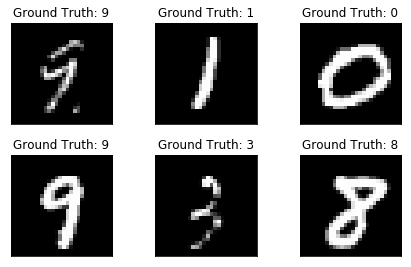

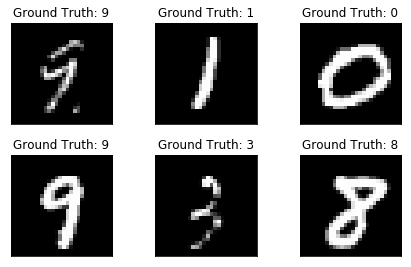

In [18]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

<strong>Build a 2-D convolutional layers.<strong/> Create a new class for the network

In [19]:
import torch.nn as nn  #layers containing trainable params
import torch.nn.functional as F #purely functional?
import torch.optim as optim

class Net(nn.Module): 
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()  # two dropout layers for regularization
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    #defines how we compute the ouput using the given layers and fns
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)